# Inestigating the Relation Between Twitter Sentiment and Stock Prices

---

## 0. Environment Prerequisites

In [0]:
!pip install spacy tweepy yfinance vaderSentiment

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import iplot
from utils import *

## 1. Aggregate analysis

### 1.1 Load historical aggregate data

In [0]:
agg = pd.read_csv('aggregate.csv', index_col=0)
agg.index = pd.to_datetime(agg.index)
agg.symbol = agg.symbol.astype(str)
# convert sentiment count to ratio
agg.neg /= agg.total
agg.pos /= agg.total
agg.neu /= agg.total
agg.head()

,High,Close,Open,Low,neg,neu,pos,total,symbol
date,,,,,,,,,
2013-05-31,75.63,74.84,75.41,74.82,0.000000,1.000000,0.000000,2.0,WMT
2013-06-03,75.80,75.68,75.06,74.64,0.039474,0.736842,0.223684,76.0,WMT
2013-06-04,76.38,75.92,75.77,75.47,0.444444,0.462963,0.092593,108.0,WMT
2013-06-05,75.95,75.25,75.72,75.07,0.166667,0.777778,0.055556,54.0,WMT
2013-06-06,75.74,75.58,75.27,74.83,0.100000,0.785714,0.114286,70.0,WMT


Inspect the table by visualizing movements of MSFT (Microsoft)

In [0]:
symbol = 'MSFT'
corp = agg[agg.symbol == symbol].sort_index()
plot_ticker(series=[corp, corp.neg, corp.pos, corp.neu],
            labels=[symbol, 'negativity', 'positivity', 'neutrality'],
            ylim=[0, 1], breaks=False)

Let's remove the trend by defining new price as $p' = p_{n+1} - p_{n}$.

Also normalize the price to [0, 1].

In [0]:
def norm_minmax(xs):
  maxi, mini = xs.max(), xs.min()
  denom = maxi if abs(maxi) > abs(mini) else mini
  return xs / abs(denom)

for col in split('Open,High,Low,Close'):
  corp['Delta'+col] = corp[col] - corp[col].shift(1)

corp['delta'] = norm_minmax(corp['DeltaClose'])
cols = split('delta,neg,pos,neu')
axs = [go.Scatter(x=corp.index, y=corp[col], name=col, connectgaps=True) for col in cols]
fig = go.Figure(data=axs, layout=mklayout(
    xaxis=dict(rangeslider_visible=True, rangebreaks=[dict(bounds=['sat', 'mon'])]),
))
fig.show()

Now, we can check for correlations in these time series...

We could say that there is a slight positive correlation of positive tweets to **change** in price, conversely, there is a slight negative correlation of the ratio of negative tweets to change in price.

In [0]:
corr = corp.dropna().corr()
corr = corr.loc[split('DeltaOpen,DeltaHigh,DeltaLow,DeltaClose'), split('pos,neu,neg')]
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).set_properties(**{'font-size': '16pt'})

,pos,neu,neg
DeltaOpen,0.30,-0.13,-0.18
DeltaHigh,0.34,-0.13,-0.24
DeltaLow,0.30,-0.07,-0.29
DeltaClose,0.32,-0.06,-0.32


Finally, we compute the same correlation coefficients for each company in the Dow Jones index (only for the closing price).

In [0]:
corrs = []
for symbol in agg.symbol.unique():
  corp = agg[agg.symbol == symbol].copy()
  corp['delta'] = corp[col] - corp[col].shift(1)
  corr = corp.dropna().corr()
  corrs.append(dict(
    symbol=symbol,
    pos=corr.loc['delta','pos'],
    neg=corr.loc['delta','neg'],
    neu=corr.loc['delta','neu']))
corrs = pd.DataFrame(corrs)
corrs.head()

,symbol,pos,neg,neu
0,WMT,0.196881,-0.265468,0.064124
1,PG,0.239643,-0.206081,-0.074294
2,MCD,0.175522,-0.191491,0.024816
3,DIS,0.223731,-0.264593,-0.101196
4,PFE,0.098407,-0.108660,-0.040222


It's interesting to see, which company price movements are most correlated to tweet sentiment:

**Optimistic gainers**

Top 5: MSFT (Microsoft), GE (General Electric), CAT, HD (Home Depot), IBM

Bottom 5: TRV (Travelers), T (AT&T), KO (Coca Cola), VZ (Verizon), PFE (Pfizer

In [0]:
corrs.sort_values('pos', ascending=False, inplace=True)
corrs.head(5)

,symbol,pos,neg,neu
23,MSFT,0.330321,-0.283633,-0.095529
14,GE,0.327986,-0.076051,-0.283461
16,CAT,0.319667,-0.351615,0.045353
8,HD,0.305868,-0.264657,-0.110991
27,IBM,0.290623,-0.402524,0.108387


In [0]:
corrs.tail(5)

,symbol,pos,neg,neu
4,PFE,0.098407,-0.108660,-0.040222
24,VZ,0.092382,-0.229562,0.029501
12,KO,0.088243,-0.146906,0.001384
26,T,0.080441,-0.185863,-0.002700
17,TRV,0.044055,-0.116357,0.045274


In [0]:
corrs.sort_values('neg', ascending=True, inplace=True)
corrs.head(5)

,symbol,pos,neg,neu
27,IBM,0.290623,-0.402524,0.108387
20,BA,0.242772,-0.357476,-0.010595
28,GS,0.252315,-0.352873,0.060282
16,CAT,0.319667,-0.351615,0.045353
29,V,0.174454,-0.328152,0.015777


In [0]:
corrs.tail(5)

,symbol,pos,neg,neu
21,JPM,0.224137,-0.125252,0.011951
17,TRV,0.044055,-0.116357,0.045274
4,PFE,0.098407,-0.108660,-0.040222
25,MRK,0.248310,-0.090426,-0.185661
14,GE,0.327986,-0.076051,-0.283461


## 2. Live data analysis

### 2.1 Download tweets

Authenticate with the Twitter API with a set of consumer and token keys/secrets.

Obviously, you have to populate the `secrets.json` file yourself.

In [0]:
import tweepy

def twitter_api(secret_path):
  import json
  with open(secret_path, 'r') as f:
    secrets = json.load(f)
  auth = tweepy.OAuthHandler(secrets['consumer_key'], secrets['consumer_secret'])
  auth.set_access_token(secrets['token_key'], secrets['token_secret'])
  return tweepy.API(auth)

api = twitter_api('secrets.json')

Add all tweets matching a given query, starting (from newest, max 7 days history).

Interrupt the cell to stop collection.

Waits 1 minute on API usage rate limit (15 min windows).

In [0]:
query = '$msft OR microsoft exclude:retweets'
csv = 'msft.csv'

In [0]:
def wait_on_error(cursor, timeout):
  import time
  while True:
    try:
      yield cursor.next()
    except:
      sleep(timeout)

def stream_tweets(query):
  cursor = tweepy.Cursor(api.search, q=query, lang='en', result_type='newest', tweet_mode='extended', count=100)
  for tweet in wait_on_error(cursor.items(), timeout=60):
    text = tweet.retweeted_status.full_text if hasattr(tweet, 'retweeted_status') else tweet.full_text
    yield dict(id=tweet.id, date=tweet.created_at, likes=tweet.favorite_count, text=text))

tweets = []
for i, x in enumerate(stream_tweets(query))
  tweets.append(x)
  if i % 1_000 == 0: print('.', end='')
  if i % 1_000_000 == 0: print()

Convert tweet timestamps from GMT to New York, to match quote data from Yahoo Finance.

Append streamed tweets to a given CSV file.

In [0]:
import pytz
new_york = pytz.timezone('America/New_York')
tweets = pd.DataFrame(tweets)
tweets.date = tweets.date.dt.tz_localize('GMT').dt.tz_convert(now_york)
tweets.to_csv(csv, mode='a', index=False, header=False)

### 2.1 (Alternative) Read tweets from csv

In [0]:
names = split('index,id,date,likes,text')
tweets = pd.read_csv('msft.csv', names=names, skipfooter=1, engine='python')
tweets.text = tweets.text.astype(str)
tweets.date = pd.to_datetime(tweets.date)
tweets = tweets.drop(columns=['index'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.



### 2.2 Calculate tweet sentiment

and zip it with the tweets dataframe

In [0]:
sent = pd.DataFrame(list(tweets.text.map(get_sentiment)))
tweets_sent = pd.concat([tweets, sent], axis=1)
tweets_sent.head()

,id,date,likes,text,bpol,bsub,vpol,vpos,vneu,vneg
0,1.269074e+18,2020-06-05 21:11:17-04:00,1.0,@monchimutt Lel when microsoft decided to look...,0.2,0.3,0.4588,0.167,0.833,0.000
1,1.269074e+18,2020-06-05 21:11:14-04:00,0.0,And it's on... my TABS!!! *insta unpin* This i...,0.0,0.0,0.6083,0.209,0.791,0.000
2,1.269074e+18,2020-06-05 21:11:08-04:00,0.0,@RhuidiG13 @Lisa____99 @Karomika420 That is sh...,0.0,0.3,0.0000,0.000,1.000,0.000
3,1.269074e+18,2020-06-05 21:11:05-04:00,0.0,@ItsFuckinSami This may be the solution\n\nhtt...,0.0,0.0,0.3182,0.277,0.723,0.000
4,1.269074e+18,2020-06-05 21:11:04-04:00,0.0,Cheers for another fucked up update \n@microsoft,-0.6,0.7,-0.3182,0.248,0.400,0.352


Let's inspect the sentiment data, by calculating some basic statistics, and visualizing interesting series

In [0]:
tweets_sent.drop(['id', 'likes'], axis=1).describe()

,bpol,bsub,vpol,vpos,vneu,vneg
count,35978.000000,35978.000000,35978.000000,35978.000000,35978.000000,35978.000000
mean,0.106955,0.354223,0.195049,0.103768,0.854902,0.041330
std,0.255012,0.295397,0.429135,0.113271,0.131114,0.082159
min,-1.000000,0.000000,-0.985700,0.000000,0.181000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.774000,0.000000
50%,0.000000,0.400000,0.177900,0.081000,0.866000,0.000000
75%,0.242424,0.550000,0.534600,0.170000,1.000000,0.056000
max,1.000000,1.000000,0.994700,0.819000,1.000000,0.808000


Polarity is in the range of [-1, +1], where -1 is the most negative sentiment and +1 is most positive sentiment.

Here we compare sentiment outputs from two different.

In [0]:
sent = tweets_sent.groupby(pd.Grouper(key='date', freq='1T')).mean()
sent = sent.rolling(window=180).mean()
plot_multi_series(sent.vpol, sent.bpol, labels=['vader polarity', 'blob polarity'], ylim=[-1, 1])

All values below are in the range [0, 1], where 0 is the lowest intensity value and 1 is the highest intensity.

In [0]:
plot_multi_series(sent.vpos, sent.vneu, sent.vneg, sent.bsub,
                  labels=['positivity', 'neutrality', 'negativity', 'subjectivity'], ylim=[0, 1])

### 2.3 Visualize tweets word clouds

1. Remove @ mentions, urls, xml escapes and extra whitespace
2. Plot a word cloud

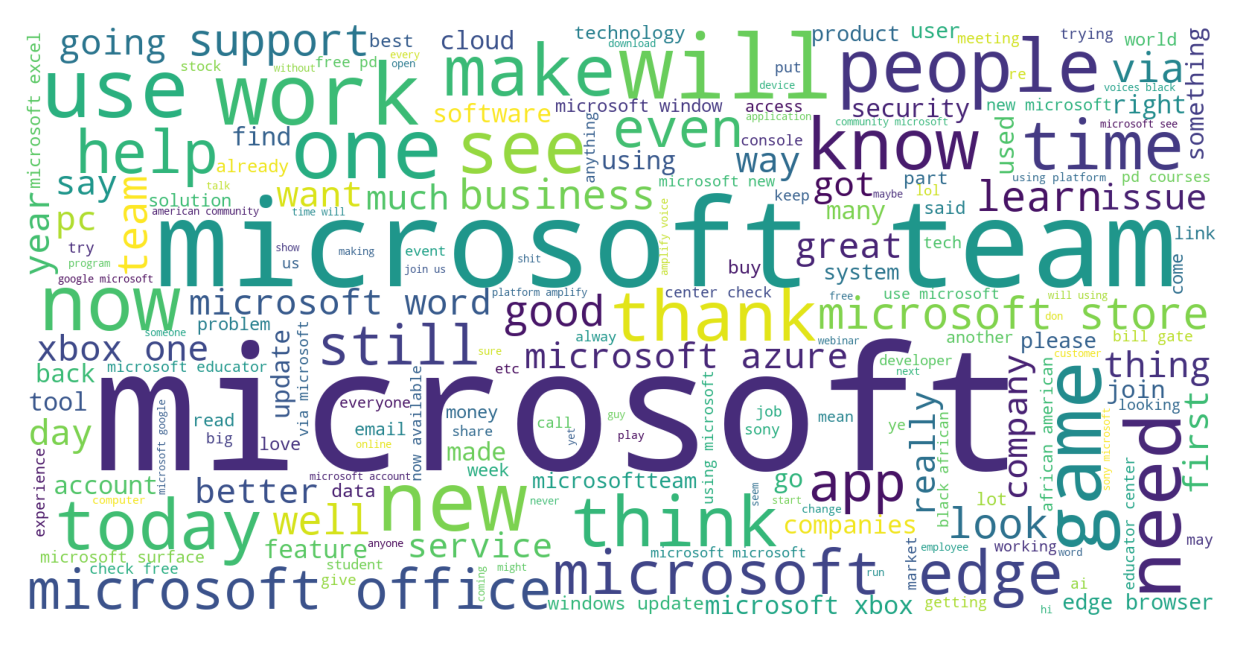

In [0]:
import re

def clean_text(text):
  # remove mentions, http urls and html escapes
  text = re.sub(r'@\S+|https?\S*|\&[A-Za-z]+\;', '', text)
  # replace whitespace substrings with a single space
  text = re.sub(r'\s+', ' ', text)
  return text

plot_wordcloud(tweets_sent.text.map(clean_text), width=1600, height=800)

### Download financial data

In [0]:
import yfinance as yf
symbol = 'MSFT'
tick = yf.Ticker(symbol)
hist = tick.history(period='10d', interval='5m')
plot_ohlc(hist)

### Visualize results

In [0]:
def plot_ticker(series, labels, ylim=None, breaks=True):
  axs = []
  iter = zip(series, labels)
  ohlc, label = next(iter)
  axs = [go.Candlestick(xaxis='x2', yaxis='y2', name=label, x=ohlc.index, open=ohlc.Open, high=ohlc.High, low=ohlc.Low, close=ohlc.Close)]
  axs += [go.Scatter(name=label, x=xs.index, y=xs, xaxis='x2', yaxis='y1', mode='lines') for xs, label in iter]
  fig = go.Figure(data=axs, layout=mklayout(
    xaxis2=dict(rangeslider_visible=True, rangebreaks=market_breaks if breaks else None),
    yaxis1=dict(domain=[0.0, 0.2], range=ylim, fixedrange=False),
    yaxis2=dict(domain=[0.25, 1.0], fixedrange=False),
  ))
  fig.show()

plot_ticker(series=[hist, sent.vpos, sent.vneu, sent.vneg, sent.bsub],
            labels=[symbol, 'positivity', 'neutrality', 'negativity', 'subjectivity'], ylim=[0, 1])

In [0]:
combined = pd.concat([hist, sent], axis=1)
combined.drop(['id', 'likes', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
combined.dropna(inplace=True)
corr = combined.corr()
# only interesting correlations
corr = corr.loc[split('Open,High,Low,Close,Volume'), split('vpol,vpos,vneu,vneg,bpol,bsub')]
# ugly, but readable :)
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).set_properties(**{'font-size': '16pt'})

,vpol,vpos,vneu,vneg,bpol,bsub
Open,0.41,0.39,-0.21,-0.17,-0.11,-0.30
High,0.39,0.37,-0.18,-0.20,-0.10,-0.31
Low,0.42,0.39,-0.22,-0.17,-0.11,-0.30
Close,0.40,0.37,-0.20,-0.18,-0.11,-0.30
Volume,-0.20,-0.11,0.11,-0.07,-0.04,-0.06
